In [1]:
import keras
import pandas as pd
import numpy as np
import glob
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras import models
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.applications import DenseNet169, ResNet50, VGG16, InceptionV3
import utilities
from keras.optimizers import Adam
import matplotlib.pyplot as plt



In [37]:
import tensorflow as tf
print(tf.__version__)

2.3.1


### Create path to directory

In [3]:
train_dir = 'data_withaug/output/train'
val_dir = 'data_withaug/output/val'
test_dir = 'data_withaug/output/test' 

train_samples =utilities.get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
val_samples = utilities.get_files(val_dir)
test_samples=utilities.get_files(test_dir) 
print(num_classes,"Classes")
print(train_samples,"Train images")
print(val_samples, "Validation images")
print(test_samples,"Test images")

39 Classes
49179 Train images
6139 Validation images
6168 Test images


## Use the ImageDataGenerator from Keras
#### This package in Keras can be used to generate augmented datasets

In [4]:
# Rescales all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 45,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   brightness_range= [0.9, 1.1],
                                   horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # Target directory
    target_size=(150, 150), #Resizes all images to 150 × 150
    batch_size=32,
    class_mode='categorical') #Because you use binary_crossentropy loss, you need binary labels


validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')



Found 49179 images belonging to 39 classes.
Found 6139 images belonging to 39 classes.


In [7]:
#Load model
dense_json_file = open('DenseNet169_retrained.json', 'r')
dense_loaded_model_json = dense_json_file.read()
dense_json_file.close()
dense_loaded_model = models.model_from_json(dense_loaded_model_json)
# load weights into new model
dense_loaded_model.load_weights("DenseNet169_retrained_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [9]:
for layer in dense_loaded_model.layers:
    layer.trainable = False
for layer in dense_loaded_model.layers[1:3]:
    layer.trainable = True

### Freeze the transfer model and re-train the classifying layers
With the retrained transfer model, train the subsequent layers to that it could classify better.

In [8]:
batch_size = 32 # the number of training examples used in the estimate of the error
epochs = 10 #number of passes the algorithm will make through the training dataset

In [10]:
dense_loaded_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
dense_loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 4, 4, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                106560    
_________________________________________________________________
dense_5 (Dense)              (None, 39)                2535      
Total params: 12,751,975
Trainable params: 106,560
Non-trainable params: 12,645,415
_________________________________________________________________


In [12]:
history = dense_loaded_model.fit_generator(
    train_generator,
    steps_per_epoch= train_samples//batch_size,
    epochs=epochs,
    validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1536/1536 [==============================] - 2309s 2s/step - loss: 0.0290 - accuracy: 0.9906 - val_loss: 0.0684 - val_accuracy: 0.9793
Epoch 2/20
1536/1536 [==============================] - 2635s 2s/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0535 - val_accuracy: 0.9860
Epoch 3/20
1536/1536 [==============================] - 2701s 2s/step - loss: 0.0198 - accuracy: 0.9932 - val_loss: 0.0583 - val_accuracy: 0.9835
Epoch 4/20
1536/1536 [==============================] - 2687s 2s/step - loss: 0.0187 - accuracy: 0.9937 - val_loss: 0.0690 - val_accuracy: 0.9824
Epoch 5/20
1536/1536 [==============================] - 2746s 2s/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.0490 - val_accuracy: 0.9876
Epoch 6/20
1536/1536 [==============================] - 2902s 2s/step - loss: 0.0161 - accuracy: 0.9939 - val_loss: 0.0397 - val_accuracy: 0.9909
Epoch 7/20
1536/1536 [==========================

### Third pass: the model is at 99.6% accuracy and 98.6% validation accuracy

### Look at train and validation accuracy and loss

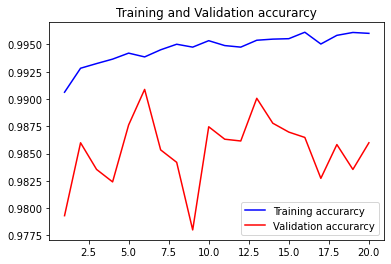

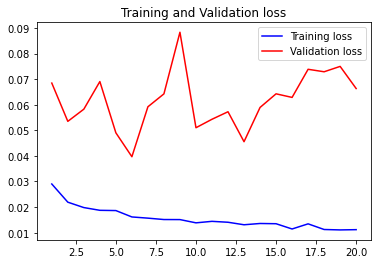

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [14]:
#save model
model_json = dense_loaded_model.to_json()
with open("dense_retrain_4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dense_loaded_model.save_weights("dense_retrain_4.h5")
from tensorflow.keras import models
models.save_model(dense_loaded_model,'dense_retrain_4.hdf5')
print("Saved model to disk")

Saved model to disk


In [81]:
#to open model
# json_file = open('baseline.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("baseline.h5")
# print("Loaded model from disk")

## Look at performance on test set

In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    test_dir, # Target directory
    target_size=(150, 150), #Resizes all images to 150 × 150
    batch_size=32,
    shuffle = False,
    class_mode='categorical') #Because you use categorical_crossentropy loss, you need categorical labels

Found 6168 images belonging to 39 classes.


In [17]:
dense_loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = dense_loaded_model.evaluate_generator(test_generator, verbose=0)
print("%s: %.2f%%" % (dense_loaded_model.metrics_names[1], score[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
accuracy: 98.65%


#### The test set has an accuracy score of 98.65%

In [21]:
labels = test_generator.class_indices
labels

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Background_without_leaves': 4,
 'Blueberry___healthy': 5,
 'Cherry___Powdery_mildew': 6,
 'Cherry___healthy': 7,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8,
 'Corn___Common_rust': 9,
 'Corn___Northern_Leaf_Blight': 10,
 'Corn___healthy': 11,
 'Grape___Black_rot': 12,
 'Grape___Esca_(Black_Measles)': 13,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
 'Grape___healthy': 15,
 'Orange___Haunglongbing_(Citrus_greening)': 16,
 'Peach___Bacterial_spot': 17,
 'Peach___healthy': 18,
 'Pepper,_bell___Bacterial_spot': 19,
 'Pepper,_bell___healthy': 20,
 'Potato___Early_blight': 21,
 'Potato___Late_blight': 22,
 'Potato___healthy': 23,
 'Raspberry___healthy': 24,
 'Soybean___healthy': 25,
 'Squash___Powdery_mildew': 26,
 'Strawberry___Leaf_scorch': 27,
 'Strawberry___healthy': 28,
 'Tomato___Bacterial_spot': 29,
 'Tomato___Early_blight': 30,
 'Tomato___Late_blight': 31,
 'Tomato__

In [22]:
test_generator.reset()

In [23]:
probabilities = dense_loaded_model.predict_generator(test_generator)
predicted_class_indices=np.argmax(probabilities,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_4.csv",index=False)

Instructions for updating:
Please use Model.predict, which supports generators.


In [24]:
train_generator.reset()
validation_generator.reset()

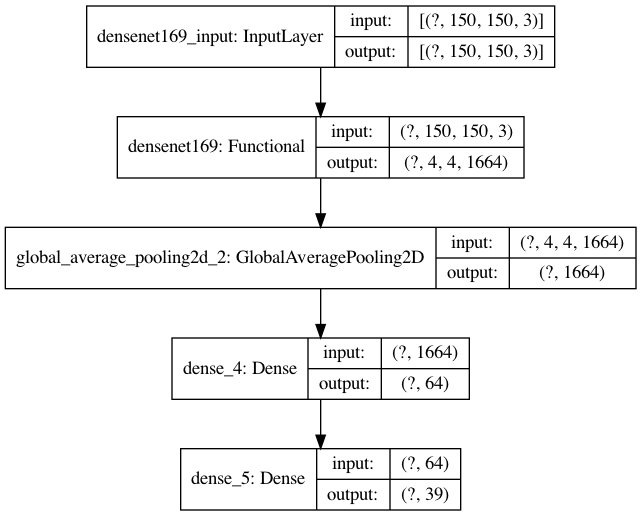

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(dense_loaded_model, to_file='model2.png', show_shapes=True, show_layer_names=True)


In [33]:
dictionary = test_generator.class_indices
plant_disease = list(dictionary.keys())
len(plant_disease)

39

#### Double check results by using the model to make predictions.

Each image is taken in by the model and then probabilities of each class are given to each image. The argmax function returns the class that image has the highest probability of belonging in.

## Confusion matrix

Text(0.5, 255.29374999999993, 'Predicted')

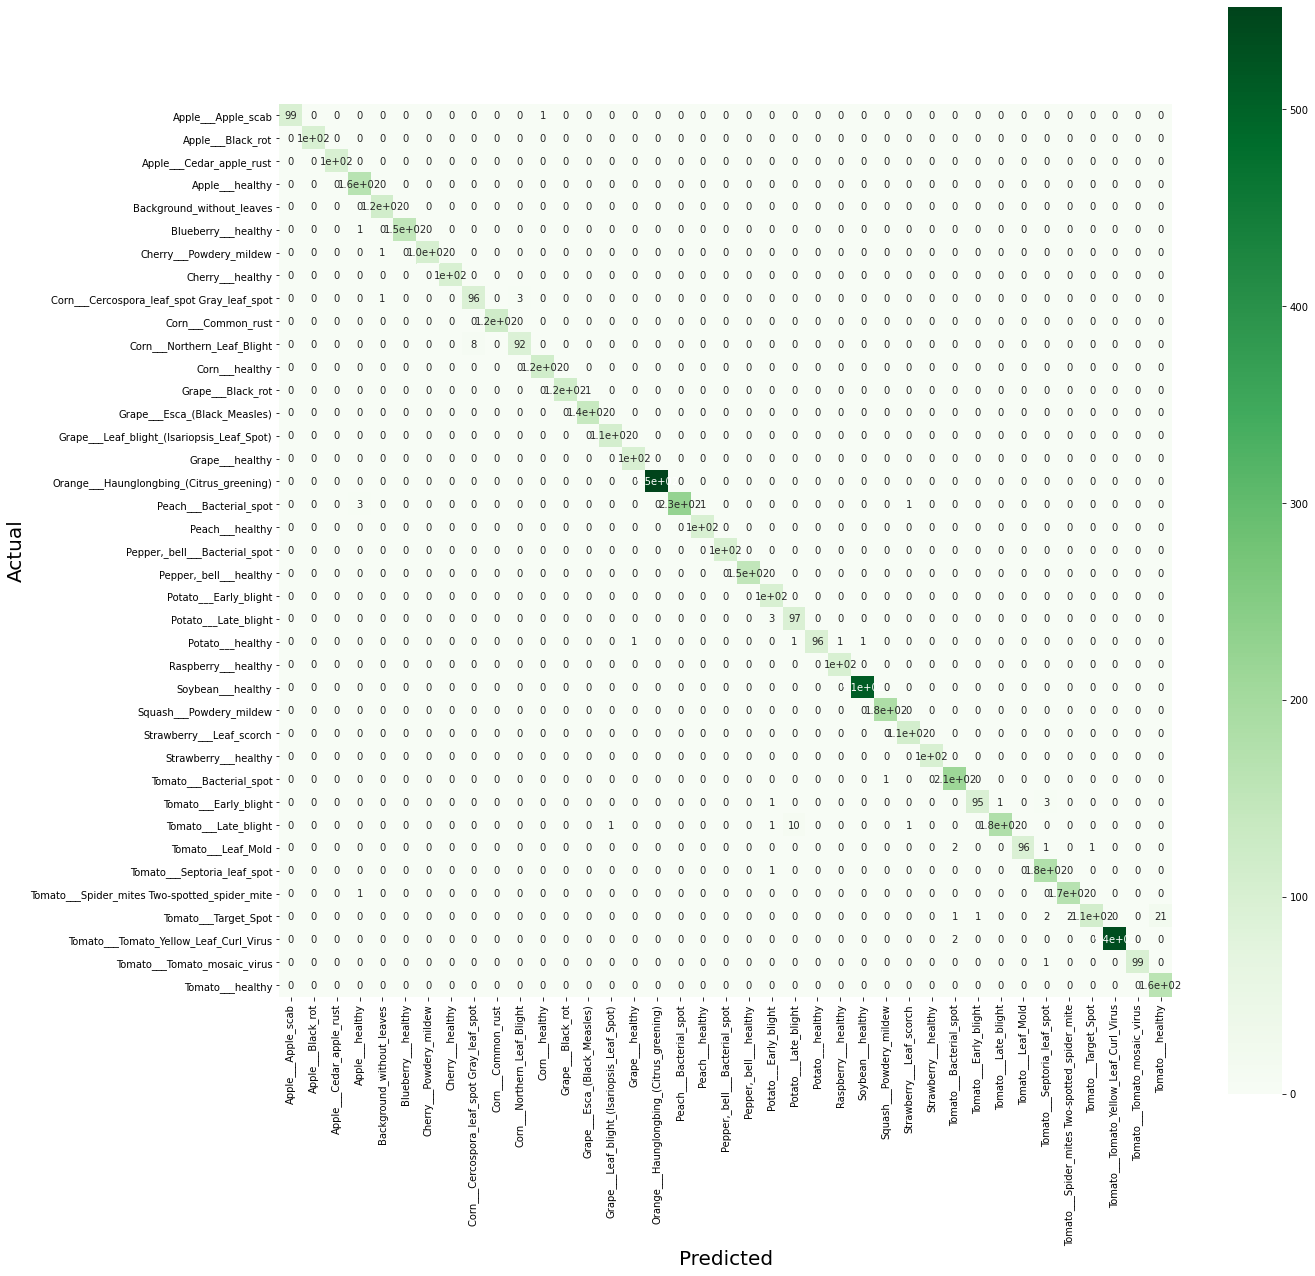

In [27]:
Y_true = test_generator.classes
Y_pred = np.argmax(probabilities, axis=1)


cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(20, 20))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=plant_disease, yticklabels=plant_disease)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)



In [28]:
ax.figure.savefig('confusion2.jpeg')

## Print classification report

In [29]:
print(classification_report(Y_true, Y_pred, target_names = plant_disease))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.99      0.99       100
                            Apple___Black_rot       1.00      1.00      1.00       100
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       100
                              Apple___healthy       0.97      1.00      0.99       165
                    Background_without_leaves       0.98      1.00      0.99       115
                          Blueberry___healthy       1.00      0.99      1.00       151
                      Cherry___Powdery_mildew       1.00      0.99      1.00       106
                             Cherry___healthy       1.00      1.00      1.00       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.96      0.94       100
                           Corn___Common_rust       1.00      1.00      1.00       120
                  Corn___Northern_Leaf_Bli